# InceptionV3 work

### Importing libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

### Read the Data

In [3]:
# Translation dictionary for class labels
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant",
    "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
    "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel",
    "dog": "cane", "cavallo": "horse", "elephant": "elefante",
    "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto",
    "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"
}

In [4]:
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

In [5]:
# Directories
directory = r'csv/raw-img'

# Data augmentation and generators
datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.15)

train_generator = datagen.flow_from_directory(directory,  
                                                target_size=(224, 224), 
                                                batch_size=32,
                                                shuffle=True,
                                                subset='training',
                                                class_mode='categorical')  

validation_generator = datagen.flow_from_directory(directory,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    shuffle=False,
                                                    subset='validation',
                                                    class_mode='categorical')

Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


In [6]:
# Translate and display class labels
class_labels = list(train_generator.class_indices.keys())

translated_labels = [translate.get(label, label) for label in class_labels]

print(f"Original Class labels: {class_labels}")
print(f"Translated Class Labels: {translated_labels}")


Original Class labels: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Translated Class Labels: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'ragno', 'squirrel']


### Show Number of Classes

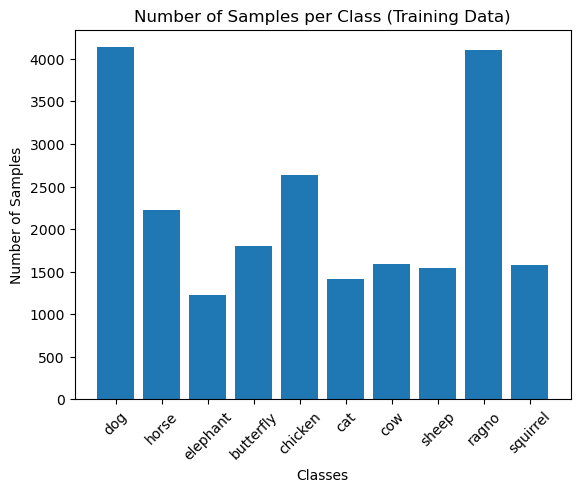

In [7]:
train_class_counts = np.bincount(train_generator.classes)
x = np.arange(len(translated_labels))
plt.bar(x, train_class_counts)
plt.xticks(x, translated_labels, rotation=45)
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Number of Samples per Class (Training Data)")
plt.show()

### Display some Data

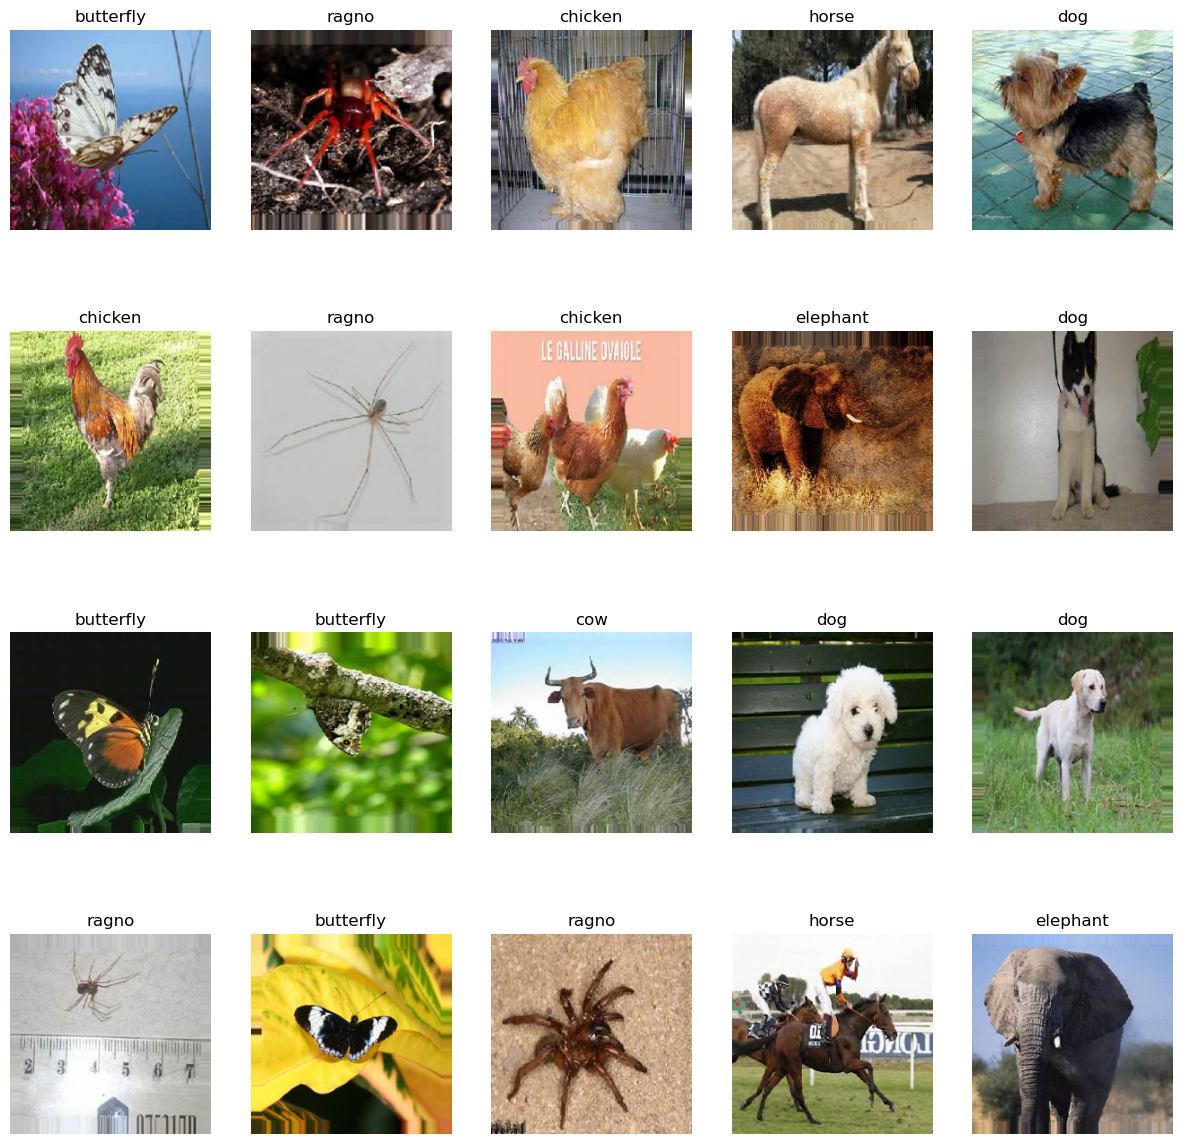

In [8]:
# Display image samples
max_images = 20
plt.figure(figsize=(15, 15))
for X_batch, y_batch in train_generator:
    for i in range(min(max_images, len(X_batch))):
        plt.subplot(4, 5, i + 1)
        plt.imshow(X_batch[i])
        plt.title(translated_labels[np.argmax(y_batch[i])])
        plt.axis('off')
    plt.show()
    break

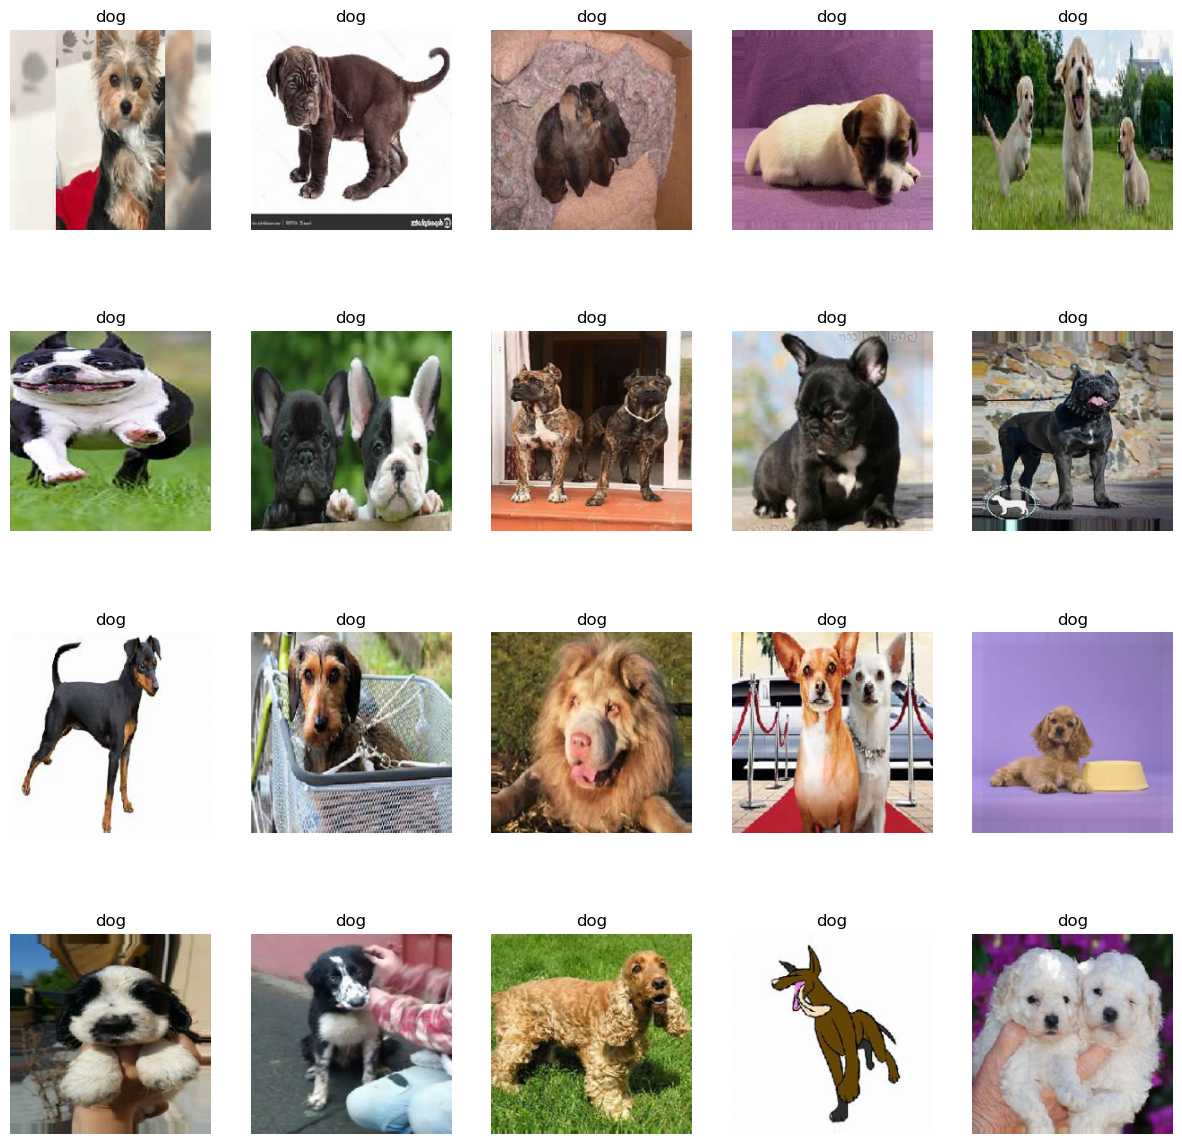

In [39]:
plt.figure(figsize=(15,15))
for X_batch, y_batch in validation_generator:
    for i in range(min(max_images, len(X_batch))):  
        plt.subplot(4, 5, i + 1)  
        plt.imshow(X_batch[i])
        plt.title(translated_labels[np.where(y_batch[i] == 1)[0][0]])  
        plt.axis('off')  
    plt.show()  
    break  

### Building InceptionV3 Model

In [9]:
# Model setup
img_height, img_width = 224, 224
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in base_model.layers:
    layer.trainable = False

In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(class_labels), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["accuracy", "Precision", "Recall"])

In [13]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),
    ModelCheckpoint('inceptionv3.keras', save_best_only=True)
]

In [15]:
# Training
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=5,
                    callbacks=callbacks)

Epoch 1/5
696/696 [==============================] - 747s 1s/step - loss: 0.1479 - accuracy: 0.9545 - precision: 0.9638 - recall: 0.9474 - val_loss: 0.1285 - val_accuracy: 0.9607 - val_precision: 0.9693 - val_recall: 0.9513 - lr: 0.0010
Epoch 2/5
696/696 [==============================] - 687s 986ms/step - loss: 0.1337 - accuracy: 0.9594 - precision: 0.9676 - recall: 0.9530 - val_loss: 0.1258 - val_accuracy: 0.9602 - val_precision: 0.9677 - val_recall: 0.9536 - lr: 0.0010
Epoch 3/5
696/696 [==============================] - 719s 1s/step - loss: 0.1238 - accuracy: 0.9590 - precision: 0.9673 - recall: 0.9538 - val_loss: 0.1294 - val_accuracy: 0.9618 - val_precision: 0.9712 - val_recall: 0.9544 - lr: 0.0010
Epoch 4/5
696/696 [==============================] - 697s 1s/step - loss: 0.1132 - accuracy: 0.9642 - precision: 0.9709 - recall: 0.9594 - val_loss: 0.1339 - val_accuracy: 0.9574 - val_precision: 0.9633 - val_recall: 0.9503 - lr: 0.0010
Epoch 5/5
696/696 [==============================

In [17]:
def plot_training_history(history, metrics, title="Training and Validation Metrics", save_path=None):
    valid_metrics = [metric for metric in metrics if metric in history.history]
    num_metrics = len(valid_metrics)
    rows = (num_metrics + 1) // 2
    fig, axs = plt.subplots(rows, 2, figsize=(14, 5 * rows))
    axs = axs.flatten()

    fig.suptitle(title, fontsize=16)

    for ax, metric in zip(axs, valid_metrics):
        ax.plot(history.history[metric], label=f'Training {metric.capitalize()}', color='blue', linestyle='-', marker='o')
        ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}', color='orange', linestyle='--', marker='x')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'Training vs. Validation {metric.capitalize()}')
        ax.legend()
        ax.grid(True)
        ax.set_ylim(0, 1)

    for i in range(num_metrics, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

metrics = ['accuracy', 'loss', 'recall', 'precision']

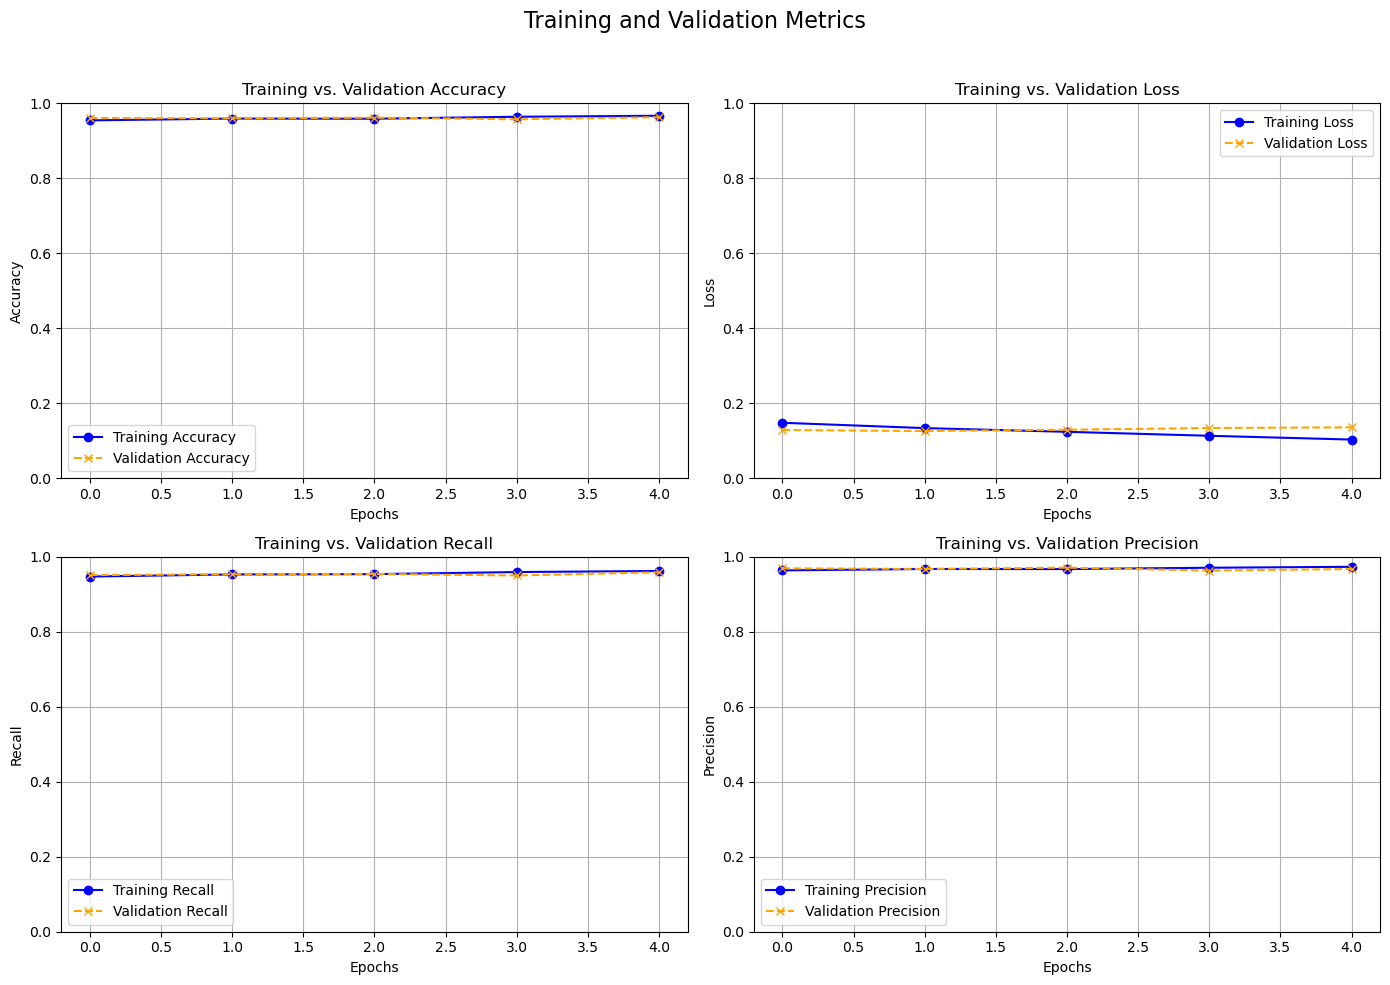

In [18]:
plot_training_history(history, metrics)

### Test Model

In [19]:
y_test = validation_generator.classes
y_pred = np.argmax(model.predict(validation_generator), axis=1)
print(classification_report(y_test, y_pred, target_names=translated_labels))

123/123 [==============================] - 108s 859ms/step
              precision    recall  f1-score   support

         dog       0.96      0.98      0.97       729
       horse       0.98      0.90      0.94       393
    elephant       0.93      0.97      0.95       216
   butterfly       0.96      0.97      0.97       316
     chicken       0.99      0.99      0.99       464
         cat       0.95      0.96      0.96       250
         cow       0.84      0.96      0.90       279
       sheep       0.96      0.85      0.90       273
       ragno       0.98      0.99      0.99       723
    squirrel       1.00      0.92      0.96       279

    accuracy                           0.96      3922
   macro avg       0.96      0.95      0.95      3922
weighted avg       0.96      0.96      0.96      3922



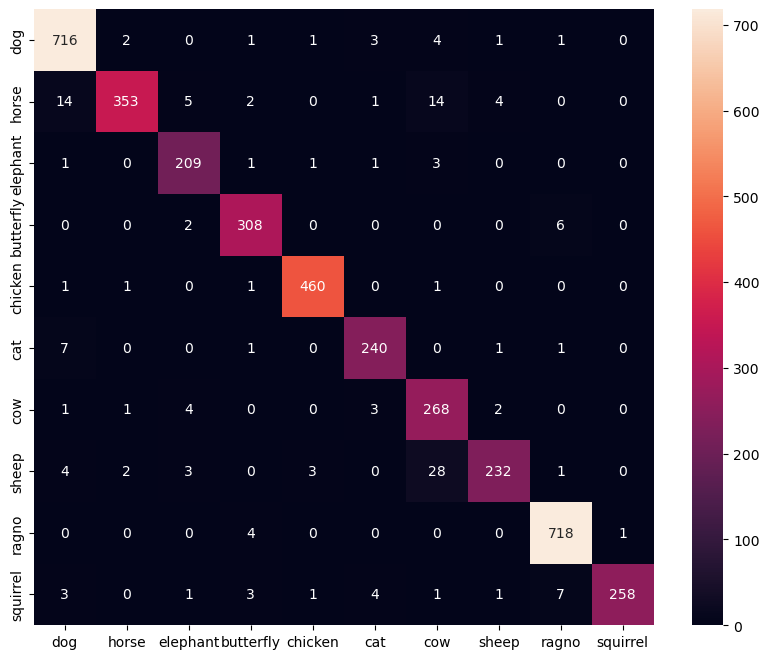

In [20]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=translated_labels, yticklabels=translated_labels)
plt.show()